In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

from tensorflow.keras.applications import VGG16, MobileNetV2, InceptionV3, DenseNet121

In [3]:
height=300
width=300
channels=3
batch_size=64

In [4]:
import pandas as pd

sdir= '/content/drive/MyDrive/DATASET/MAGANG/06.FINAL'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths         labels
0  /content/drive/MyDrive/DATASET/MAGANG/06.FINAL...  LightRoasting
1  /content/drive/MyDrive/DATASET/MAGANG/06.FINAL...  LightRoasting
2  /content/drive/MyDrive/DATASET/MAGANG/06.FINAL...  LightRoasting
3  /content/drive/MyDrive/DATASET/MAGANG/06.FINAL...  LightRoasting
4  /content/drive/MyDrive/DATASET/MAGANG/06.FINAL...  LightRoasting
labels
LightRoasting     564
MediumRoasting    564
DarkRoasting      564
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

# Define the proportions for train, validation, and test splits
train_split = 0.7
valid_split = 0.2
test_split = 0.1

# Splitting the data with stratification
train_df, test_valid_df = train_test_split(df, train_size=train_split, stratify=df['labels'], shuffle=True, random_state=123)
valid_df, test_df = train_test_split(test_valid_df, train_size=valid_split/(valid_split + test_split), stratify=test_valid_df['labels'], shuffle=True, random_state=123)

print('train_df length:', len(train_df), '  valid_df length:', len(valid_df), '  test_df length:', len(test_df))

# Check class distribution in each set
print('\nTrain set class distribution:')
print(train_df['labels'].value_counts())
print('\nValid set class distribution:')
print(valid_df['labels'].value_counts())
print('\nTest set class distribution:')
print(test_df['labels'].value_counts())

train_df length: 1184   valid_df length: 338   test_df length: 170

Train set class distribution:
labels
DarkRoasting      395
LightRoasting     395
MediumRoasting    394
Name: count, dtype: int64

Valid set class distribution:
labels
MediumRoasting    113
LightRoasting     113
DarkRoasting      112
Name: count, dtype: int64

Test set class distribution:
labels
DarkRoasting      57
MediumRoasting    57
LightRoasting     56
Name: count, dtype: int64


In [6]:
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels',
                                   target_size=img_size, class_mode='categorical',
                                   color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels',
                                        target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  34   test steps:  5
Found 1184 validated image filenames belonging to 3 classes.
Found 338 validated image filenames belonging to 3 classes.
Found 170 validated image filenames belonging to 3 classes.
['DarkRoasting', 'LightRoasting', 'MediumRoasting']


In [7]:
# Retrieve class indices from the generator
class_indices = train_gen.class_indices

# Reverse the dictionary to get label to index mapping
label_to_index = {v: k for k, v in class_indices.items()}

# Print label to index mapping
print("Label to Index Mapping:")
print(label_to_index)

Label to Index Mapping:
{0: 'DarkRoasting', 1: 'LightRoasting', 2: 'MediumRoasting'}


In [8]:
def create_model():
    base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(height, width, 3))

    # Freezing all layers except the last one of InceptionV3
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    return model

In [9]:
# Inisialisasi model
model = create_model()
print(model.summary())

87910968/87910968 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 22065443 (84.17 MB)
Trainable params: 26265

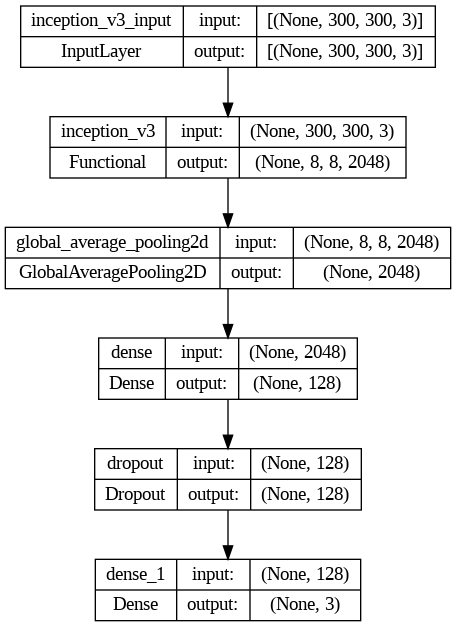

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_gen, epochs=50, validation_data=valid_gen,
                               verbose=2, callbacks=[reduce_lr, early_stop])

Epoch 1/50
19/19 - 644s - loss: 0.6093 - accuracy: 0.7204 - val_loss: 0.2845 - val_accuracy: 0.8905 - lr: 0.0010 - 644s/epoch - 34s/step
Epoch 2/50
19/19 - 7s - loss: 0.3097 - accuracy: 0.8708 - val_loss: 0.2041 - val_accuracy: 0.9290 - lr: 0.0010 - 7s/epoch - 390ms/step
Epoch 3/50
19/19 - 7s - loss: 0.2488 - accuracy: 0.9062 - val_loss: 0.1931 - val_accuracy: 0.9172 - lr: 0.0010 - 7s/epoch - 391ms/step
Epoch 4/50
19/19 - 8s - loss: 0.2221 - accuracy: 0.9147 - val_loss: 0.1717 - val_accuracy: 0.9320 - lr: 0.0010 - 8s/epoch - 396ms/step
Epoch 5/50
19/19 - 7s - loss: 0.1716 - accuracy: 0.9392 - val_loss: 0.1411 - val_accuracy: 0.9556 - lr: 0.0010 - 7s/epoch - 387ms/step
Epoch 6/50
19/19 - 7s - loss: 0.1559 - accuracy: 0.9434 - val_loss: 0.1371 - val_accuracy: 0.9556 - lr: 0.0010 - 7s/epoch - 393ms/step
Epoch 7/50
19/19 - 7s - loss: 0.1503 - accuracy: 0.9409 - val_loss: 0.1906 - val_accuracy: 0.9201 - lr: 0.0010 - 7s/epoch - 388ms/step
Epoch 8/50
19/19 - 7s - loss: 0.1257 - accuracy: 0.95

In [12]:
# Define the directory where you want to save the model
model_name = 'Inception_30'
save_dir = '/content/drive/MyDrive/DATASET/MAGANG/'

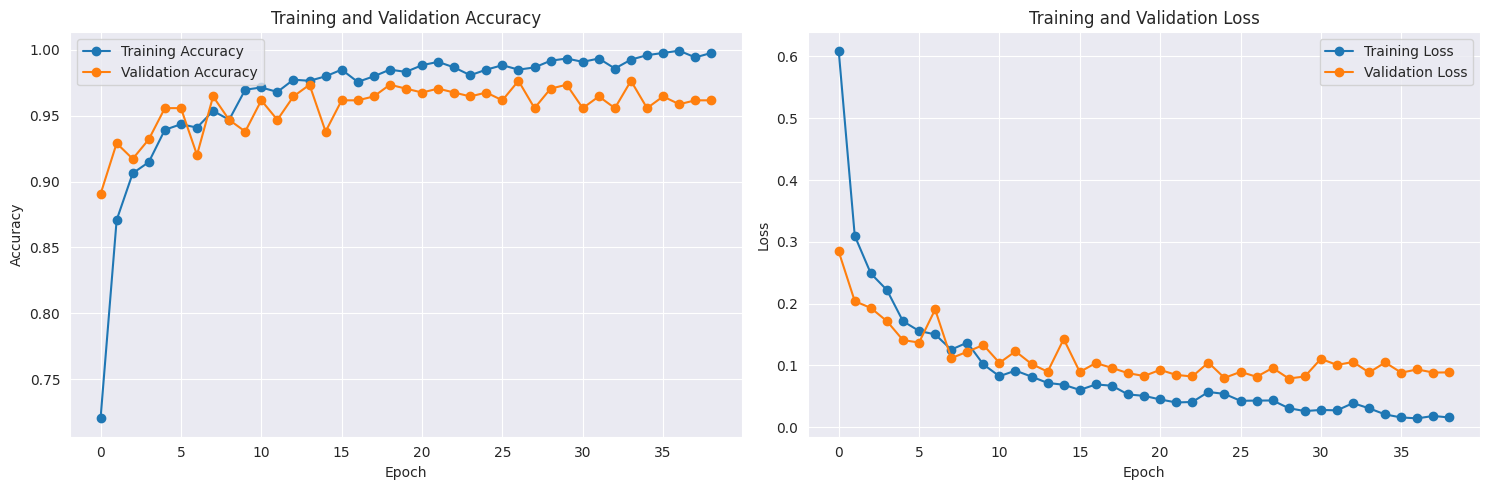

5/5 [==============================] - 1s 161ms/step - loss: 0.0812 - accuracy: 0.9647
accuracy on the test set is 96.47 %


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at: /content/drive/MyDrive/DATASET/MAGANG/Inception_30-my_subject-96.47.h5


In [15]:
import matplotlib.pyplot as plt
import os

# Function to print text in color
def print_in_color(text, color, background):
    print(f"\033[38;2;{color[0]};{color[1]};{color[2]}m\033[48;2;{background[0]};{background[1]};{background[2]}m{text}\033[m")

# Plotting accuracy and loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Assuming 'model', 'test_gen', 'test_batch_size', and 'test_steps' are defined
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100
msg = f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))

# Assuming 'model_name' and 'save_dir' are defined
subject = "my_subject"
save_id = str(model_name + '-' + subject + '-' + str(acc)[:str(acc).rfind('.') + 3] + '.h5')
save_loc = os.path.join(save_dir, save_id)
model.save(save_loc)

print(f"Model saved at: {save_loc}")

5/5 [==============================] - 2s 158ms/step


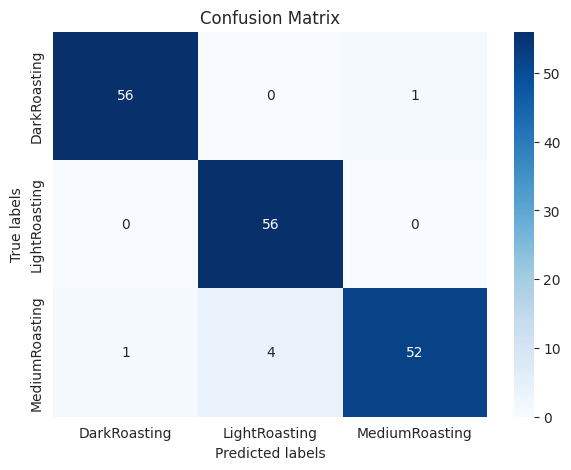

In [16]:
# Confusion Matrix and Classification Report
predictions = model.predict(test_gen)
class_labels = ['DarkRoasting', 'LightRoasting', 'MediumRoasting']

# Get predicted classes and true classes
y_pred_classes = np.argmax(predictions, axis=1)
y_true = test_gen.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Create classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)

# Display classification report
print(report)

                precision    recall  f1-score   support

  DarkRoasting       0.98      0.98      0.98        57
 LightRoasting       0.93      1.00      0.97        56
MediumRoasting       0.98      0.91      0.95        57

      accuracy                           0.96       170
     macro avg       0.97      0.96      0.96       170
  weighted avg       0.97      0.96      0.96       170

